In [2]:
# Install PySpark
!pip install pyspark

In [4]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("FraudDetectionAnalysis").getOrCreate()

# Upload the CSV file manually in Colab or use drive mount
file_path = "/content/Ban k_Transaction_Fraud_Detection.csv"  # adjust if different
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Check Schema and first few rows
df.printSchema()
df.show(5)


root
 |-- Customer_ID: string (nullable = true)
 |-- Customer_Name: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Bank_Branch: string (nullable = true)
 |-- Account_Type: string (nullable = true)
 |-- Transaction_ID: string (nullable = true)
 |-- Transaction_Date: string (nullable = true)
 |-- Transaction_Time: timestamp (nullable = true)
 |-- Transaction_Amount: double (nullable = true)
 |-- Merchant_ID: string (nullable = true)
 |-- Transaction_Type: string (nullable = true)
 |-- Merchant_Category: string (nullable = true)
 |-- Account_Balance: double (nullable = true)
 |-- Transaction_Device: string (nullable = true)
 |-- Transaction_Location: string (nullable = true)
 |-- Device_Type: string (nullable = true)
 |-- Is_Fraud: integer (nullable = true)
 |-- Transaction_Currency: string (nullable = true)
 |-- Customer_Contact: string (nullable = true)
 |-- 

In [5]:
# Check for null values
from pyspark.sql.functions import col, isnan, when, count

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Drop rows with nulls
df_clean = df.dropna()

# Drop duplicate rows
df_clean = df_clean.dropDuplicates()

df_clean.show(5)


+-----------+-------------+------+---+-----+----+-----------+------------+--------------+----------------+----------------+------------------+-----------+----------------+-----------------+---------------+------------------+--------------------+-----------+--------+--------------------+----------------+-----------------------+--------------+
|Customer_ID|Customer_Name|Gender|Age|State|City|Bank_Branch|Account_Type|Transaction_ID|Transaction_Date|Transaction_Time|Transaction_Amount|Merchant_ID|Transaction_Type|Merchant_Category|Account_Balance|Transaction_Device|Transaction_Location|Device_Type|Is_Fraud|Transaction_Currency|Customer_Contact|Transaction_Description|Customer_Email|
+-----------+-------------+------+---+-----+----+-----------+------------+--------------+----------------+----------------+------------------+-----------+----------------+-----------------+---------------+------------------+--------------------+-----------+--------+--------------------+----------------+--------

In [6]:
# Class distribution
df_clean.groupBy("Is_Fraud").count().show()

# Total transactions and average amount by type
df_clean.groupBy("Transaction_Type").agg(
    {"Transaction_Amount": "mean", "*": "count"}
).withColumnRenamed("avg(Transaction_Amount)", "avg_amount").show()

# Top 5 highest transactions
df_clean.orderBy(col("Transaction_Amount").desc()).show(5)


+--------+------+
|Is_Fraud| count|
+--------+------+
|       1| 10088|
|       0|189912|
+--------+------+

+----------------+--------+------------------+
|Transaction_Type|count(1)|        avg_amount|
+----------------+--------+------------------+
|    Bill Payment|   40040| 49441.27943806209|
|        Transfer|   39953| 49527.46332816053|
|      Withdrawal|   39777|49646.531528269974|
|          Credit|   40180|49576.178178695875|
|           Debit|   40050|49499.191409987274|
+----------------+--------+------------------+

+--------------------+-----------------+------+---+----------+---------+----------------+------------+--------------------+----------------+-------------------+------------------+--------------------+----------------+-----------------+---------------+------------------+--------------------+-----------+--------+--------------------+----------------+-----------------------+--------------------+
|         Customer_ID|    Customer_Name|Gender|Age|     State|     City

In [17]:
# Feature Engineering
#Transaction Amount Z-Score (Outlier Detection)

from pyspark.sql.functions import mean, stddev

stats = df_clean.select(mean("Transaction_Amount"), stddev("Transaction_Amount")).first()
mean_amt, std_amt = stats[0], stats[1]

df_clean = df_clean.withColumn(
    "Amount_Z_Score",
    (col("Transaction_Amount") - mean_amt) / std_amt
)
df_clean.select("Transaction_Amount", "Amount_Z_Score").show(5)


+------------------+-------------------+
|Transaction_Amount|     Amount_Z_Score|
+------------------+-------------------+
|          62184.19| 0.4429192439034538|
|          78739.28| 1.0227442318458688|
|          17770.77|-1.1126150791344411|
|          91720.19| 1.4773872440089908|
|           21818.2| -0.970858009197173|
+------------------+-------------------+
only showing top 5 rows



In [21]:
#Correlation Analysis
#Check correlation between numerical features and fraud.
for col_name in ["Transaction_Amount", "Amount_Z_Score"]:
    corr = df_clean.stat.corr(col_name, "Is_Fraud")
    print(f"Correlation between {col_name} and Is_Fraud: {corr}")


Correlation between Transaction_Amount and Is_Fraud: -0.002099505305879923
Correlation between Amount_Z_Score and Is_Fraud: -0.0020995053058798703


Converting to pandas for visualization


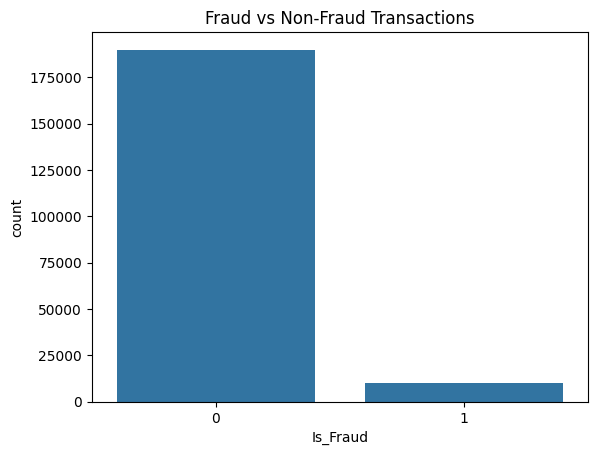

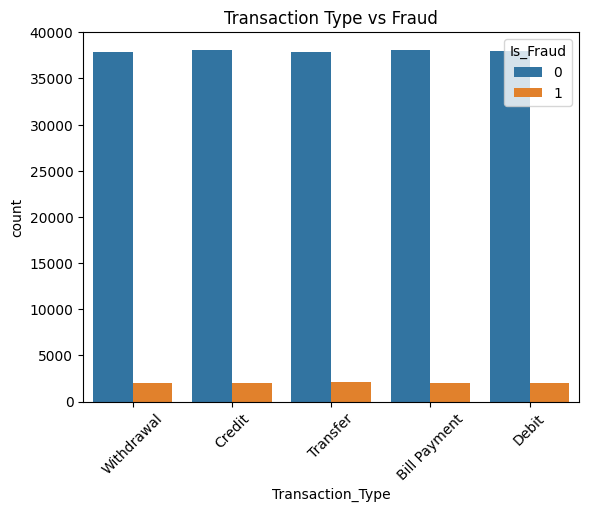

In [7]:
# Convert to Pandas for Visualization
df_pd = df_clean.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

# Fraud vs Non-Fraud Count
sns.countplot(data=df_pd, x='Is_Fraud')
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()

# Transaction Type Distribution
sns.countplot(data=df_pd, x='Transaction_Type', hue='Is_Fraud')
plt.title("Transaction Type vs Fraud")
plt.xticks(rotation=45)
plt.show()




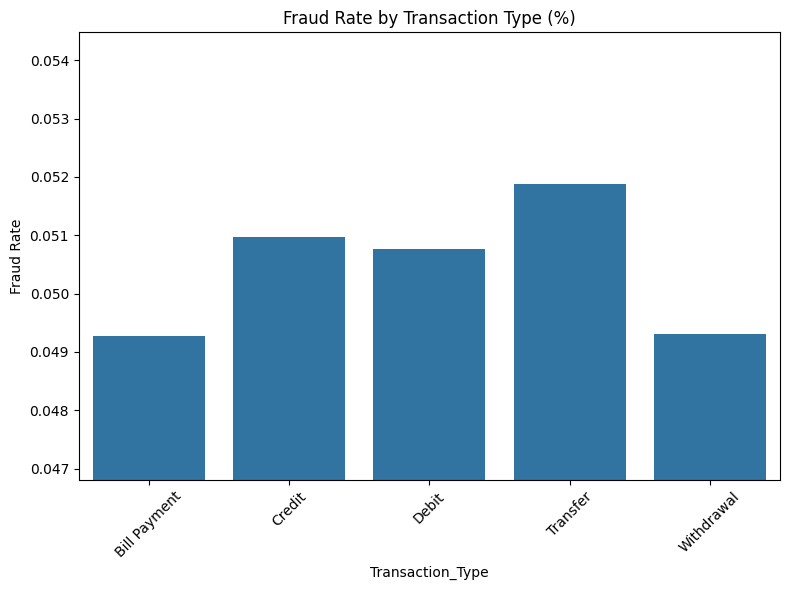

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fraud_rate = df_pd.groupby('Transaction_Type')['Is_Fraud'].mean().reset_index()
fraud_rate.columns = ['Transaction_Type', 'Fraud_Rate']

plt.figure(figsize=(8, 6))  # Optional: make the plot a bit larger
sns.barplot(data=fraud_rate, x='Transaction_Type', y='Fraud_Rate')
plt.title("Fraud Rate by Transaction Type (%)")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)

# Zoom in: set y-axis limits just below the minimum and just above the maximum fraud rate
min_rate = fraud_rate['Fraud_Rate'].min()
max_rate = fraud_rate['Fraud_Rate'].max()
plt.ylim(min_rate * 0.95, max_rate * 1.05)  # Adjust as needed

plt.tight_layout()
plt.show()


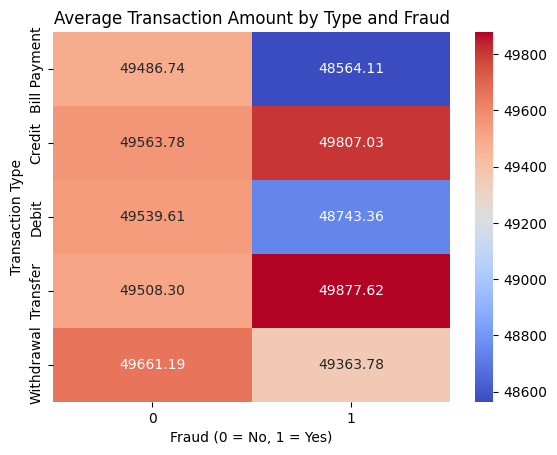

In [9]:
pivot_table = df_pd.pivot_table(
    index='Transaction_Type',
    columns='Is_Fraud',
    values='Transaction_Amount',
    aggfunc='mean'
)

sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Average Transaction Amount by Type and Fraud")
plt.ylabel("Transaction Type")
plt.xlabel("Fraud (0 = No, 1 = Yes)")
plt.show()


In [11]:
import plotly.express as px

fig = px.sunburst(df_pd, path=['Transaction_Type', 'Is_Fraud'], values='Transaction_Amount',
                  color='Is_Fraud', color_continuous_scale='RdBu',
                  title='Fraud Contribution by Transaction Type')
fig.show()


